In [262]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils import resample


In [263]:
original_dataset = pd.read_csv('hrs_data_needed_for_calcs_with_inc_groups.csv')

C:\Users\mahes\AppData\Local\Temp\ipykernel_46812\3540995078.py:1: DtypeWarning: Columns (34,35,36,37,38,39,40,41,42,48,49,50,51,52,53,54,55,56,62,63,64,65,66,67,68,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  original_dataset = pd.read_csv('hrs_data_needed_for_calcs_with_inc_groups.csv')


In [264]:
new_dataset = pd.DataFrame({
    'ID': np.repeat(range(1, len(original_dataset) + 1), 14),
    'Wave': np.tile(range(1, 15), len(original_dataset)),
    'Gender': np.repeat(original_dataset['ragender'], 14),
    'Age': np.nan,
    'DeathAge': np.repeat(original_dataset['radage_y'], 14),
    'IncomeGroup': np.nan,
    'Curr_HealthState': np.nan
})

In [265]:
new_dataset.isna().sum()

ID                       0
Wave                     0
Gender                   0
Age                 591262
DeathAge            360164
IncomeGroup         591262
Curr_HealthState    591262
dtype: int64

In [266]:
for i in range(1, 15):
    wave_suffix = f"{i:02d}"
    age_group_col = f"r{i}agey_b"
    income_group_col = f"r{i}inc_group"
    health_state_col = f"Status_wave_{i}"

    new_dataset.loc[new_dataset['Wave'] == i, 'Age'] = original_dataset[age_group_col].values
    new_dataset.loc[new_dataset['Wave'] == i, 'IncomeGroup'] = original_dataset[income_group_col].values
    new_dataset.loc[new_dataset['Wave'] == i, 'Curr_HealthState'] = original_dataset[health_state_col].values

C:\Users\mahes\AppData\Local\Temp\ipykernel_46812\3891662965.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Healthy' 'Healthy' 'Healthy' ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_dataset.loc[new_dataset['Wave'] == i, 'Curr_HealthState'] = original_dataset[health_state_col].values


In [267]:
new_dataset.head(10)

,ID,Wave,Gender,Age,DeathAge,IncomeGroup,Curr_HealthState
0,1,1,1,54.0,57.0,2.0,Healthy
0,1,2,1,56.0,57.0,2.0,Healthy
0,1,3,1,NaN,57.0,NaN,Dead
0,1,4,1,NaN,57.0,NaN,Dead
0,1,5,1,NaN,57.0,NaN,Dead
0,1,6,1,NaN,57.0,NaN,Dead
0,1,7,1,NaN,57.0,NaN,Dead
0,1,8,1,NaN,57.0,NaN,Dead
0,1,9,1,NaN,57.0,NaN,Dead
0,1,10,1,NaN,57.0,NaN,Dead


In [268]:
new_dataset.columns = ["ID", "Wave", "Gender", "Age", "DeathAge", "IncomeGroup", "Curr_HealthState"]
filtered_dataset = new_dataset.copy()
filtered_dataset['Age'] = np.where((filtered_dataset['Curr_HealthState'] == "Dead") &
                                   (filtered_dataset['Age'].isna()) &
                                   (~filtered_dataset['DeathAge'].isna()),
                                   filtered_dataset['DeathAge'],
                                   filtered_dataset['Age'])
filtered_dataset.isna().sum()

ID                       0
Wave                     0
Gender                   0
Age                 217902
DeathAge            360164
IncomeGroup         326644
Curr_HealthState    218755
dtype: int64

In [269]:
filtered_dataset['Curr_HealthState'] = np.where(filtered_dataset['Curr_HealthState'] == "", np.nan, filtered_dataset['Curr_HealthState'])

In [270]:
filtered_dataset.isna().sum()

ID                       0
Wave                     0
Gender                   0
Age                 217902
DeathAge            360164
IncomeGroup         326644
Curr_HealthState    218755
dtype: int64

In [271]:
filtered_dataset = filtered_dataset.drop(columns=['DeathAge'])

In [272]:
filtered_dataset.isna().sum()

ID                       0
Wave                     0
Gender                   0
Age                 217902
IncomeGroup         326644
Curr_HealthState    218755
dtype: int64

In [273]:
filtered_dataset = filtered_dataset.sort_values(by=['ID', 'Wave'])

In [274]:
filtered_dataset = filtered_dataset[~(filtered_dataset['Age'].isna()  &
                                     filtered_dataset['IncomeGroup'].isna() & filtered_dataset['Curr_HealthState'].isna())]

In [275]:
filtered_dataset = filtered_dataset.dropna()

In [276]:
filtered_dataset.isna().sum()

ID                  0
Wave                0
Gender              0
Age                 0
IncomeGroup         0
Curr_HealthState    0
dtype: int64

In [277]:
filtered_dataset.head(10)

,ID,Wave,Gender,Age,IncomeGroup,Curr_HealthState
0,1,1,1,54.0,2.0,Healthy
0,1,2,1,56.0,2.0,Healthy
1,2,1,2,57.0,2.0,Healthy
1,2,2,2,59.0,2.0,Healthy
1,2,3,2,62.0,3.0,Healthy
1,2,4,2,63.0,3.0,Healthy
1,2,5,2,65.0,3.0,Healthy
2,3,1,1,56.0,3.0,Healthy
2,3,2,1,58.0,3.0,Healthy
2,3,3,1,60.0,3.0,Healthy


In [278]:
filtered_dataset['Prev_HealthState'] = filtered_dataset['Curr_HealthState'].shift()
filtered_dataset['Prev_ID'] = filtered_dataset['ID'].shift()
filtered_dataset["Prev_HealthState"] = np.where(filtered_dataset["Prev_ID"] == filtered_dataset["ID"], filtered_dataset["Prev_HealthState"], None)

In [279]:
filtered_dataset.head(100)

,ID,Wave,Gender,Age,IncomeGroup,Curr_HealthState,Prev_HealthState,Prev_ID
0,1,1,1,54.0,2.0,Healthy,None,NaN
0,1,2,1,56.0,2.0,Healthy,Healthy,1.0
1,2,1,2,57.0,2.0,Healthy,None,1.0
1,2,2,2,59.0,2.0,Healthy,Healthy,2.0
1,2,3,2,62.0,3.0,Healthy,Healthy,2.0
...,...,...,...,...,...,...,...,...
9,10,12,1,76.0,1.0,NH,Healthy,10.0
10,11,1,2,44.0,2.0,Healthy,None,10.0
10,11,2,2,46.0,1.0,Healthy,Healthy,11.0
10,11,3,2,48.0,1.0,Healthy,Healthy,11.0


In [280]:
filtered_dataset = filtered_dataset.dropna()
filtered_dataset = filtered_dataset[filtered_dataset['Prev_HealthState']!='Dead']
filtered_dataset_2 = filtered_dataset.copy()
filtered_dataset_2["Curr_HealthState"] = np.where(filtered_dataset_2["Curr_HealthState"] == "Dead", 0, 1)
filtered_dataset_2 = filtered_dataset_2.drop(columns=['Prev_ID'])
filtered_dataset = filtered_dataset.drop(columns=['Prev_ID'])
filtered_dataset.head(100)

,ID,Wave,Gender,Age,IncomeGroup,Curr_HealthState,Prev_HealthState
0,1,2,1,56.0,2.0,Healthy,Healthy
1,2,2,2,59.0,2.0,Healthy,Healthy
1,2,3,2,62.0,3.0,Healthy,Healthy
1,2,4,2,63.0,3.0,Healthy,Healthy
1,2,5,2,65.0,3.0,Healthy,Healthy
...,...,...,...,...,...,...,...
10,11,11,2,64.0,1.0,Healthy,Healthy
10,11,12,2,66.0,1.0,Healthy,Healthy
10,11,13,2,68.0,1.0,Healthy,Healthy
10,11,14,2,70.0,1.0,Healthy,Healthy


In [281]:
filtered_dataset_2.head(10)

,ID,Wave,Gender,Age,IncomeGroup,Curr_HealthState,Prev_HealthState
0,1,2,1,56.0,2.0,1,Healthy
1,2,2,2,59.0,2.0,1,Healthy
1,2,3,2,62.0,3.0,1,Healthy
1,2,4,2,63.0,3.0,1,Healthy
1,2,5,2,65.0,3.0,1,Healthy
2,3,2,1,58.0,3.0,1,Healthy
2,3,3,1,60.0,3.0,1,Healthy
2,3,4,1,62.0,3.0,1,Healthy
2,3,5,1,64.0,3.0,1,Healthy
2,3,6,1,66.0,3.0,1,Healthy


In [282]:
print("Class counts before downsampling:")
print(filtered_dataset['Curr_HealthState'].value_counts())

majority_class = 'Healthy'
minority_classes = filtered_dataset['Curr_HealthState'].unique()[filtered_dataset['Curr_HealthState'].unique() != majority_class]
downsampled_majority_class = pd.DataFrame()
desired_healthy_size = 15000

for health_state in filtered_dataset['Curr_HealthState'].unique():
    if health_state == majority_class:
        downsampled_majority_class = pd.concat([downsampled_majority_class,
                                                filtered_dataset[filtered_dataset['Curr_HealthState'] == health_state].sample(desired_healthy_size, replace=False, random_state=10)])
    else:
        minority_class_data = filtered_dataset[filtered_dataset['Curr_HealthState'] == health_state]
        undersample_size = min(len(minority_class_data), desired_healthy_size)
        undersampled_minority_class = minority_class_data.sample(undersample_size, replace=False, random_state=42)
        downsampled_majority_class = pd.concat([downsampled_majority_class, undersampled_minority_class])

downsampled_majority_class = downsampled_majority_class.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nClass counts after downsampling:")
print(downsampled_majority_class['Curr_HealthState'].value_counts())

Class counts before downsampling:
Curr_HealthState
Healthy      194880
HHC           12972
Dead           5455
NH             4959
HC and NH      3367
Name: count, dtype: int64

Class counts after downsampling:
Curr_HealthState
Healthy      15000
HHC          12972
Dead          5455
NH            4959
HC and NH     3367
Name: count, dtype: int64


In [283]:
downsampled_majority_class['Curr_HealthState'] = downsampled_majority_class['Curr_HealthState'].astype('category').cat.codes
downsampled_majority_class['Prev_HealthState'] = downsampled_majority_class['Prev_HealthState'].astype('category').cat.codes

In [284]:
X = downsampled_majority_class.drop('Curr_HealthState', axis=1)
y = downsampled_majority_class['Curr_HealthState']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [285]:
X_train.isna().sum()

ID                  0
Wave                0
Gender              0
Age                 0
IncomeGroup         0
Prev_HealthState    0
dtype: int64

In [286]:
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

features = ['Age', 'Gender', 'IncomeGroup', 'Prev_HealthState']
X = downsampled_majority_class[features]
y = downsampled_majority_class['Curr_HealthState']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [287]:
model = Pipeline([
    ('encoder', ColumnTransformer(
        transformers=[
            ('gender', OneHotEncoder(), ['Gender']),
            ('income_group', OneHotEncoder(), ['IncomeGroup']),
        ],
        remainder='passthrough'
    )),
    ('classifier', SVC(kernel='linear', C=1))
])

In [288]:
model.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('gender', OneHotEncoder(),
                                                  ['Gender']),
                                                 ('income_group',
                                                  OneHotEncoder(),
                                                  ['IncomeGroup'])])),
                ('classifier', SVC(C=1, kernel='linear'))])

In [289]:
y_pred_train = model.predict(X_train)
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.37      0.01      0.01      3761
           1       0.00      0.00      0.00      2337
           2       0.37      0.54      0.44      9135
           3       0.53      0.79      0.64     10482
           4       0.00      0.00      0.00      3512

    accuracy                           0.46     29227
   macro avg       0.25      0.27      0.22     29227
weighted avg       0.35      0.46      0.37     29227



C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [290]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.28      0.00      0.01      1694
           1       0.00      0.00      0.00      1030
           2       0.36      0.55      0.43      3837
           3       0.54      0.79      0.64      4518
           4       0.00      0.00      0.00      1447

    accuracy                           0.45     12526
   macro avg       0.24      0.27      0.22     12526
weighted avg       0.34      0.45      0.37     12526



C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [291]:
baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [292]:
y_pred_train_baseline = baseline_model.predict(X_train)
print(classification_report(y_train,y_pred_train_baseline))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3761
           1       0.00      0.00      0.00      2337
           2       0.00      0.00      0.00      9135
           3       0.36      1.00      0.53     10482
           4       0.00      0.00      0.00      3512

    accuracy                           0.36     29227
   macro avg       0.07      0.20      0.11     29227
weighted avg       0.13      0.36      0.19     29227



C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [293]:
y_pred_baseline = baseline_model.predict(X_test)
print("Classification Report for Baseline Model:\n", classification_report(y_test, y_pred_baseline))

accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print("Accuracy for Baseline Model:", accuracy_baseline)

Classification Report for Baseline Model:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1694
           1       0.00      0.00      0.00      1030
           2       0.00      0.00      0.00      3837
           3       0.36      1.00      0.53      4518
           4       0.00      0.00      0.00      1447

    accuracy                           0.36     12526
   macro avg       0.07      0.20      0.11     12526
weighted avg       0.13      0.36      0.19     12526

Accuracy for Baseline Model: 0.36068976528820057


C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [294]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [295]:
X_train.isna().sum()

Age                 0
Gender              0
IncomeGroup         0
Prev_HealthState    0
dtype: int64

In [296]:
print("Class counts before downsampling:")
print(filtered_dataset_2['Curr_HealthState'].value_counts())

majority_class = 'Healthy'
minority_classes = filtered_dataset_2['Curr_HealthState'].unique()[filtered_dataset_2['Curr_HealthState'].unique() != majority_class]
downsampled_majority_class = pd.DataFrame()
desired_healthy_size = 5455

for health_state in filtered_dataset_2['Curr_HealthState'].unique():
    if health_state == majority_class:
        downsampled_majority_class = pd.concat([downsampled_majority_class,
                                                filtered_dataset_2[filtered_dataset_2['Curr_HealthState'] == health_state].sample(desired_healthy_size, replace=False, random_state=10)])
    else:
        minority_class_data = filtered_dataset_2[filtered_dataset_2['Curr_HealthState'] == health_state]
        undersample_size = min(len(minority_class_data), desired_healthy_size)
        undersampled_minority_class = minority_class_data.sample(undersample_size, replace=False, random_state=42)
        downsampled_majority_class = pd.concat([downsampled_majority_class, undersampled_minority_class])

downsampled_majority_class = downsampled_majority_class.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nClass counts after downsampling:")
print(downsampled_majority_class['Curr_HealthState'].value_counts())

Class counts before downsampling:
Curr_HealthState
1    216178
0      5455
Name: count, dtype: int64

Class counts after downsampling:
Curr_HealthState
1    5455
0    5455
Name: count, dtype: int64


In [297]:
downsampled_majority_class['Curr_HealthState'] = downsampled_majority_class['Curr_HealthState'].astype('category').cat.codes
downsampled_majority_class['Prev_HealthState'] = downsampled_majority_class['Prev_HealthState'].astype('category').cat.codes

In [298]:
X = downsampled_majority_class.drop('Curr_HealthState', axis=1)
y = downsampled_majority_class['Curr_HealthState']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [299]:
features = ['Age', 'Gender', 'IncomeGroup', 'Prev_HealthState']
X = downsampled_majority_class[features]
y = downsampled_majority_class['Curr_HealthState']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [300]:
model = Pipeline([
    ('encoder', ColumnTransformer(
        transformers=[
            ('gender', OneHotEncoder(), ['Gender']),
            ('income_group', OneHotEncoder(), ['IncomeGroup']),
        ],
        remainder='passthrough'
    )),
    ('classifier', SVC(kernel='linear', C=1))
])

model.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('gender', OneHotEncoder(),
                                                  ['Gender']),
                                                 ('income_group',
                                                  OneHotEncoder(),
                                                  ['IncomeGroup'])])),
                ('classifier', SVC(C=1, kernel='linear'))])

In [301]:
y_pred_train = model.predict(X_train)
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72      3811
           1       0.73      0.68      0.70      3826

    accuracy                           0.71      7637
   macro avg       0.71      0.71      0.71      7637
weighted avg       0.71      0.71      0.71      7637



In [302]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.74      0.72      1644
           1       0.73      0.70      0.71      1629

    accuracy                           0.72      3273
   macro avg       0.72      0.72      0.72      3273
weighted avg       0.72      0.72      0.72      3273



In [303]:
baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [304]:
y_pred_train_baseline = baseline_model.predict(X_train)
print(classification_report(y_train,y_pred_train_baseline))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3811
           1       0.50      1.00      0.67      3826

    accuracy                           0.50      7637
   macro avg       0.25      0.50      0.33      7637
weighted avg       0.25      0.50      0.33      7637



C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [305]:
y_pred_baseline = baseline_model.predict(X_test)
print("Classification Report for Baseline Model:\n", classification_report(y_test, y_pred_baseline))

accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print("Accuracy for Baseline Model:", accuracy_baseline)

Classification Report for Baseline Model:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1644
           1       0.50      1.00      0.66      1629

    accuracy                           0.50      3273
   macro avg       0.25      0.50      0.33      3273
weighted avg       0.25      0.50      0.33      3273

Accuracy for Baseline Model: 0.4977085242896425


C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mahes\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [306]:
y_pred

array([0, 1, 0, ..., 0, 1, 1], dtype=int8)

In [307]:
y_pred_s = pd.Series(y_pred)
y_pred_s = y_pred_s.rename('Curr_HealthState_Pred')
y_pred_s = y_pred_s.reset_index()
y_pred_s = y_pred_s.drop(['index'], axis=1)
y_pred_s

,Curr_HealthState_Pred
0,0
1,1
2,0
3,1
4,0
...,...
3268,0
3269,0
3270,0
3271,1


In [308]:
y_test_s = y_test.reset_index()
y_test_s = y_test_s.drop(['index'], axis=1)
y_test_s

,Curr_HealthState
0,0
1,1
2,0
3,1
4,0
...,...
3268,1
3269,0
3270,1
3271,1


In [309]:
X_test_s = X_test.reset_index()
X_test_s = X_test_s.drop(['index'], axis=1)
X_test_s['Actual'] = y_test_s['Curr_HealthState']
X_test_s['Predicted'] = y_pred_s['Curr_HealthState_Pred']
X_test_s = X_test_s.drop(['Age','Gender','Prev_HealthState'],axis=1)
X_test_s = X_test_s.melt(id_vars='IncomeGroup',value_name='Counts_new',var_name='Origin')
X_test_s['Counts_new'] += 1
X_test_s['Counts_new'] = X_test_s['Counts_new'].map({1:1, 2:0})
X_test_s_counts = X_test_s.groupby(['IncomeGroup','Origin']).sum()
X_test_s, X_test_s_counts

(      IncomeGroup     Origin  Counts_new
 0             2.0     Actual           1
 1             2.0     Actual           0
 2             1.0     Actual           1
 3             3.0     Actual           0
 4             1.0     Actual           1
 ...           ...        ...         ...
 6541          1.0  Predicted           1
 6542          1.0  Predicted           1
 6543          2.0  Predicted           1
 6544          1.0  Predicted           0
 6545          1.0  Predicted           0
 
 [6546 rows x 3 columns],
                        Counts_new
 IncomeGroup Origin               
 1.0         Actual            971
             Predicted        1066
 2.0         Actual            591
             Predicted         616
 3.0         Actual             82
             Predicted          24)

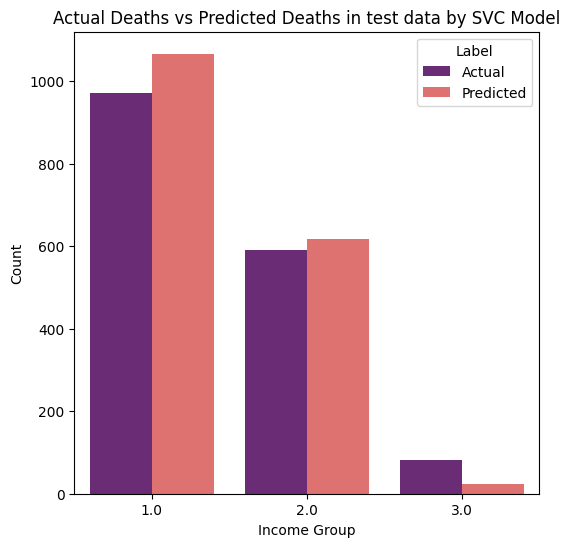

In [310]:
plt.figure(figsize=(6, 6))
ax = sns.barplot(x='IncomeGroup', y='Counts_new',hue='Origin',data=X_test_s_counts, palette='magma')
plt.xlabel("Income Group")
plt.ylabel("Count")
plt.title("Actual Deaths vs Predicted Deaths in test data by SVC Model")
plt.legend(title="Label", loc="upper right")
plt.show()